# Meeting material with Dr. Qi (June. 23rd, 2020)

This notebook is summarizing the works what I did after ICESat2 Hackweek Program (https://icesat-2hackweek.github.io/learning-resources/tutorials/getting_started/).

I learned basic concept of ICESat-2 and hdf5 file format and how to use jupyter and python and collaborate with other using git-hub. The group work was focused on cryosphere, so I extended my work to examine the water level changes on water bodies.

I set the Tonle's Sap Lake as ROI due to its large areas.

I also made three jupyter notebooks (download - process - mapping & plotting) that can allow our teams to learn how to extract water levels using ICESat-2.

In this notebook, I will start from loading the ICESat-2.

I already downloaded ATL13 (inland water level) with three kinds of water level: 
* ht_water_surf (m): water surface height for each short segment (app. 100 signal photons)
* ht_ortho (m): orthometric height EGM2008 converted from ellipsoidal height
* water_depth (m): depth from the mean water surface to detected botton

## Step 1: Check the ICEsat-2 in one beam

ICESat-2 has 6 beams in one track. I chose one for showing the ICESat-2.

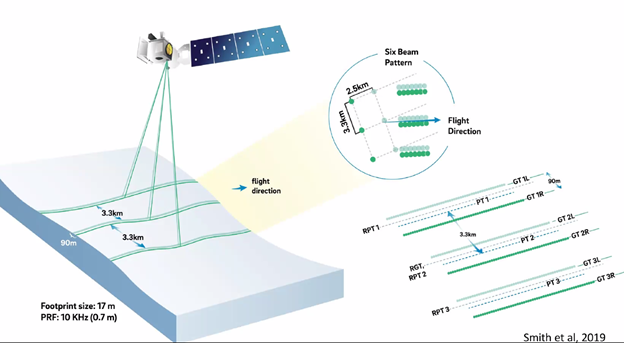

### Load modules

In [ ]:
from icepyx import icesat2data as ipd
import pandas as pd
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipyleaflet import Map, GeoData, basemaps, basemaps, basemap_to_tiles, CircleMarker, LayerGroup
import os
import shutil
import re
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
%matplotlib widget
%load_ext autoreload
%autoreload 2
from pprint import pprint
%matplotlib inline

### Load files

In [ ]:
##### load files
## set the directory
data_home = Path('/home/jovyan/ICESat_water_level/extraction/download/')
## list them up and check them
files= list(data_home.glob('*.h5'))
## choose a file as an example
file_latest = files[37]

##### function of reading alt13
def alt13_to_df(filename, beam):    
    f = h5py.File(filename, 'r')
    f_beam = f[beam]
    lat = f_beam['segment_lat'][:]
    long = f_beam['segment_lon'][:]
    ws = f_beam['ht_water_surf'][:]
    ws_sd = f_beam['stdev_water_surf'][:]
    ws_err = f_beam['err_ht_water_surf'][:]
    ortho = f_beam['ht_ortho'][:]
    wd = f_beam['water_depth'][:]
    alt13_df = pd.DataFrame({'Latitude':lat,'Longitude':long,'SurfaceH':ws,
                            'SH_SD':ws_sd, 'SH_error':ws_err,'OrthoH':ortho,
                            'WaterD':wd})
    return alt13_df

In [ ]:
with h5py.File(file_latest, 'r') as f:
    lat = f['gt2r']['segment_lat'][:]
    long = f['gt2r']['segment_lon'][:]
## create it to the dataframe
test_df = pd.DataFrame({'Latitude':lat,'Longitude':long})

### Mapping

In [ ]:
#### Tonlesap Lake (TSL)
sp_ex = [103.643, 12.375, 104.667, 13.287]
### Mapping process
center = ((sp_ex[1]+sp_ex[3])/2,(sp_ex[0]+sp_ex[2])/2)
basemap = basemaps.Stamen.Terrain
m = Map(center=center, zoom=9, basemap=basemap)
#map_gdp = GeoData(geo_dataframe = test_gdf, icon_size=[5,5])

### Ipyleaflet does not provide points, so I made a function for making circles
def create_marker(row):
    lat_lon = (row["Latitude"], row["Longitude"])
    return CircleMarker(location=lat_lon,
                    radius = 3,
                    color = "red",
                    fill_color = "black",
                    weight=1)

markers = test_df.apply(create_marker,axis=1)
layer_group = LayerGroup(layers=tuple(markers.values))
m.add_layer(layer_group)
m

### Plotting

In [ ]:
gt21 = alt13_to_df(file_latest,'gt2r')

# mapping the water surface
fig=plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(gt21['Longitude'],gt21['SurfaceH'],markersize=0.25, label='all segements')
h_leg=ax.legend()
plt.title('Water Surface')
ax.set_xlabel('Longitude')
ax.set_ylabel('Water Surface, m')
plt.show()

# mapping the orthometri heights
fig=plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(gt21['Longitude'],gt21['OrthoH'],markersize=0.25, label='all segements')
h_leg=ax.legend()
plt.title('Orthometric Heights')
ax.set_xlabel('Longitude')
ax.set_ylabel('Orthometric Heights, m')
plt.show()

# mapping the water depth
fig=plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(gt21['Longitude'],gt21['WaterD'],markersize=0.25, label='all segements')
h_leg=ax.legend()
plt.title('Water Depth')
ax.set_xlabel('Longitude')
ax.set_ylabel('Water Depth, m')
plt.show()

Through mapping three types of water level, the `water depth` is insignificant. Since the `water depth` was calculated from differences between the mean water surface to detected bottom, difficulties in detecting bottom might lead to inaccurate water depth. The Tonle Sap is large lake so the water depth might be useless, but other small water bodies (e.g., wetlands) might show accurate water depth.
We need to figure out what `water surface height` and `orthometric height` indicate. According to the document, `water surface height` is height reported for each short segment with reference to WGS84 ellipsoid. `orthometric height` is height EGM2008 converted from ellipsoidal height.

## Step 2: Mapping the water level changes

### Showing water level for all beams from one track

In [31]:
### bounds of Tonle Sap Lake
sp_ex = [103.643, 104.667, 12.375, 13.287]

In [32]:
## function for mapping the water level from every beam
def ic2_map_wl_beams(file, bound, water_levels):
    fig = plt.figure(figsize=(9,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(bound, crs=ccrs.PlateCarree())
    beam = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']
    for i in beam:
        ic2 = alt13_to_df(file,i)
        plt.scatter(ic2['Longitude'], ic2['Latitude'], s=10, c=ic2[water_levels], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
    plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')

    ##load Google Sat.Map
    #request = cimgt.GoogleTiles(style='satellite')
    request = cimgt.Stamen('terrain-background')
    ax.add_image(request, 7)

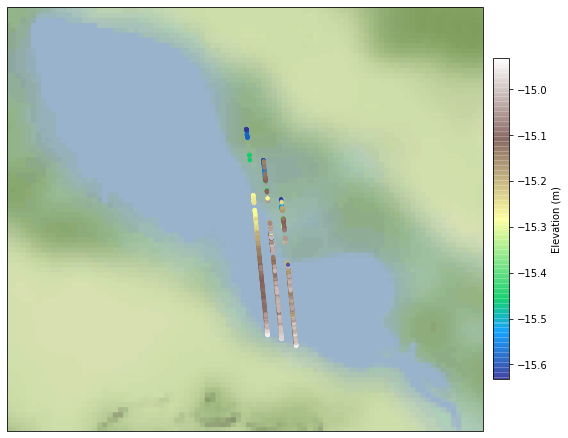

In [33]:
ic2_map_wl_beams(file_latest,sp_ex,'SurfaceH')

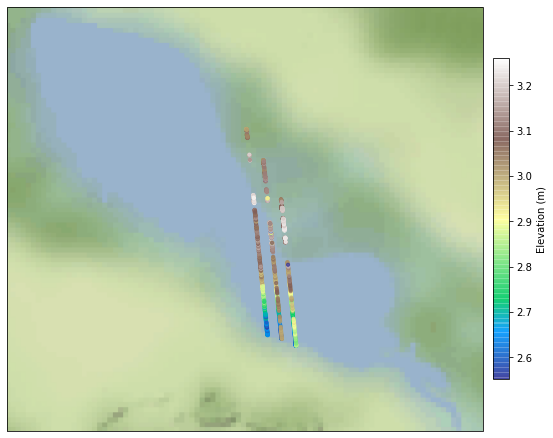

In [34]:
ic2_map_wl_beams(file_latest,sp_ex,'OrthoH')

### Mapping all tracks on the TSL

In [35]:
D_dict={}
error_count=0
for ff in files:
    try:
        D_dict[ff]=alt13_to_df(ff, 'gt2l')
    except KeyError as e:
        ##print(f'file {ff} encountered error {e}')
        error_count += 1

Text(0.5, 1.0, 'Tracks of gt2l on TSL')

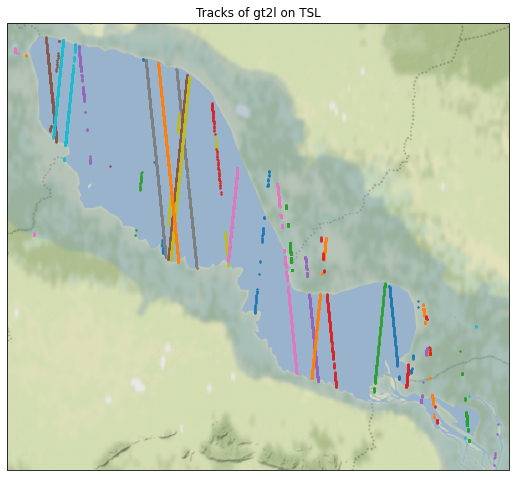

In [36]:
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(sp_ex, crs=ccrs.PlateCarree())
for index,Di in D_dict.items():
    plt.scatter(Di['Longitude'], Di['Latitude'],s=2)

request = cimgt.Stamen('terrain-background')
ax.add_image(request, 10)
plt.title("Tracks of gt2l on TSL")

### Mapping the water level from all beams of all tracks

In [37]:
D_dict_beams={}
error_count=0
beam = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']
for fff in files:
    for bb in beam:
        try:
            D_dict_beams[str(fff)+'_'+str(bb)]=alt13_to_df(fff, bb)
        except KeyError as e:
            ##print(f'file {fff} encountered error {e}')
            error_count += 1

In [38]:
def ic2_map_wl_beams_all(dic, bound, water_levels,title):
    fig = plt.figure(figsize=(9,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(bound, crs=ccrs.PlateCarree())
    for index,Di in dic.items():
        plt.scatter(Di['Longitude'], Di['Latitude'],s=2,c=Di[water_levels], alpha=.7)
   
    request = cimgt.Stamen('terrain-background')
    ax.add_image(request, 10)
    plt.title(title)
    plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')

#### Surface water height

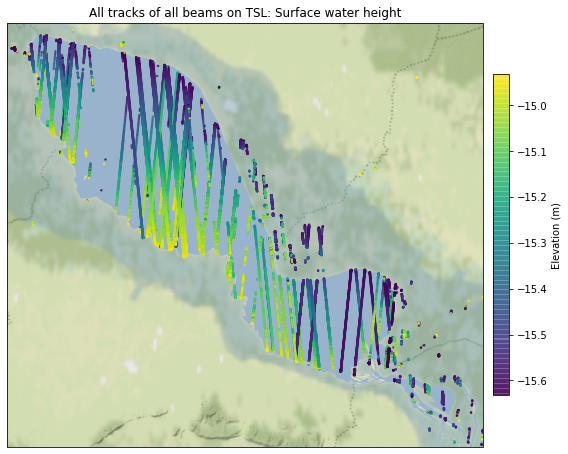

In [39]:
ic2_map_wl_beams_all(D_dict_beams,sp_ex,'SurfaceH',"All tracks of all beams on TSL: Surface water height")

#### Orthometric height

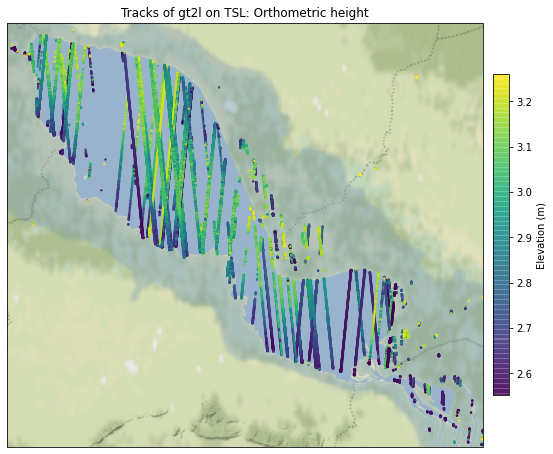

In [40]:
ic2_map_wl_beams_all(D_dict_beams,sp_ex,'OrthoH',"Tracks of gt2l on TSL: Orthometric height")

## Step 3: Plotting the water level changes

I tried to plot the graphs by grouping reference ground track (RGT). I can show temporal water level changes for the track.

In [41]:
new_dict = {}
for dd in range(0,len(list(D_dict))):
    list_dd = str(list(D_dict)[dd])
    rgt_inf = list_dd.split("_")[5]
    new_dict.update({rgt_inf: list(D_dict.values())[dd]})

In [42]:
list_0969 = [4,8,12,23,33,36]
list_0961 = [2,7,18,25,28,35]
list_0461 = [0,3,22,24,29]

In [43]:
def plot_photons (se_list, in_dic_key, in_dic_cal, waterL, title, bound):
    test_dict = {}
    for i in se_list:
        listed = str(list(in_dic_key.keys())[i])[4:6]
        test_dict.update({listed:list(in_dic_cal.values())[i]})
        
    fig=plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    for ii in list(test_dict):
        ax.plot(test_dict[ii]['Longitude'],test_dict[ii][waterL],markersize=0.25, label=ii)

    h_leg=ax.legend()
    plt.title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(waterL)
    plt.show()
    ## function for mapping the water level 
    def ic2_map_wl2(dicts, bound, water_levels):
        fig = plt.figure(figsize=(6,4))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent(bound, crs=ccrs.PlateCarree())
        for i in dicts:
            plt.scatter(dicts[i]['Longitude'], dicts[i]['Latitude'], s=10, c=dicts[i][water_levels], alpha=.7, transform=ccrs.PlateCarree(), cmap='terrain')
        plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
        ##load Google Sat.Map
        #request = cimgt.GoogleTiles(style='satellite')
        request = cimgt.Stamen('terrain-background')
        ax.add_image(request, 7)
        plt.title(title)
    ic2_map_wl2(test_dict,bound,waterL)

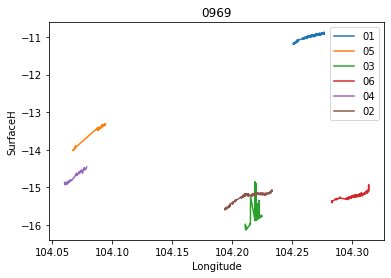

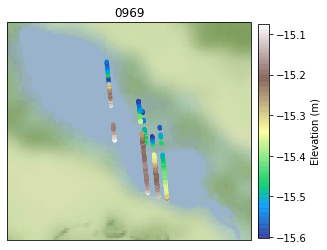

In [44]:
plot_photons(list_0969,new_dict,D_dict,'SurfaceH','0969',sp_ex)

In [ ]:
plot_photons(list_0969,new_dict,D_dict,'OrthoH','0969',sp_ex)

## Need to do
1. Which water level among surface water height and orthometric height is chose
2. There are so many gaps. This is because of different locations despite of same rgt, according to the map. What can we do?
    - Need to do additional literature reviews for tracking temporal water levels using ICESat1/2
    - Need to find futher official documents.